# 4. Find weights to apply to account for sample selection

The counts we found in [./3_servs_lf.ipynb](./3_servs_lf.ipynb) are much too low. Here we will try to understand the objects thrown away at each stage.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))
import datetime
print("This notebook was executed on: \n{}".format(datetime.datetime.now()))

This notebook was run with herschelhelp_internal version: 
017bb1e (Mon Jun 18 14:58:59 2018 +0100) [with local modifications]
This notebook was executed on: 
2018-11-05 12:08:13.902162


In [50]:
import numpy as np
from astropy.table import Table

%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from astropy import units as u
from astropy.coordinates import SkyCoord

from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge

In Gruppioni et al. (2017) they apply weights due to missing photometric redshifts in the application of the Vmax method

$$
\Phi (L,z) = \frac{1}{\Delta L} \sum_i \frac{1}{w_i V_{\textrm{max}, i}}
$$


There are various stages to the selection:

1. Survey selection. The object must be bright enough to be detected by at least one of the observing surveys.

2. Our detection criteria. We insist objects must have at least two optical and at least 2 near infrared detections.

3. Photometric redshift. Objects must have a redshift. What determines whether an object gets a redshift is not entirely understood.

4. XID+ fluxes. To pass to CIGALE the object must have at least two FIR fluxes with s/n greater than 5.

5. CIGALE fit.

First, lets look at the numbers.


In [3]:
#dmu = '/Users/rs548/GitHub/dmu_products/'
dmu = '/mnt/hedam/dmu_products/'
cat = Table.read(dmu + 'dmu32/dmu32_ELAIS-N1/data/ELAIS-N1_20171016_10pc.fits')

In [4]:
cat.colnames

['help_id',
 'field',
 'ra',
 'dec',
 'hp_idx',
 'ebv',
 'redshift',
 'zspec',
 'f_wfc_u',
 'ferr_wfc_u',
 'f_ap_wfc_u',
 'ferr_ap_wfc_u',
 'm_wfc_u',
 'merr_wfc_u',
 'm_ap_wfc_u',
 'merr_ap_wfc_u',
 'flag_wfc_u',
 'f_megacam_u',
 'ferr_megacam_u',
 'f_ap_megacam_u',
 'ferr_ap_megacam_u',
 'm_megacam_u',
 'merr_megacam_u',
 'm_ap_megacam_u',
 'merr_ap_megacam_u',
 'flag_megacam_u',
 'f_suprime_g',
 'ferr_suprime_g',
 'f_ap_suprime_g',
 'ferr_ap_suprime_g',
 'm_suprime_g',
 'merr_suprime_g',
 'm_ap_suprime_g',
 'merr_ap_suprime_g',
 'flag_suprime_g',
 'f_megacam_g',
 'ferr_megacam_g',
 'f_ap_megacam_g',
 'ferr_ap_megacam_g',
 'm_megacam_g',
 'merr_megacam_g',
 'm_ap_megacam_g',
 'merr_ap_megacam_g',
 'flag_megacam_g',
 'f_gpc1_g',
 'ferr_gpc1_g',
 'f_ap_gpc1_g',
 'ferr_ap_gpc1_g',
 'm_gpc1_g',
 'merr_gpc1_g',
 'm_ap_gpc1_g',
 'merr_ap_gpc1_g',
 'flag_gpc1_g',
 'f_wfc_g',
 'ferr_wfc_g',
 'f_ap_wfc_g',
 'ferr_ap_wfc_g',
 'm_wfc_g',
 'merr_wfc_g',
 'm_ap_wfc_g',
 'merr_ap_wfc_g',
 'flag_wf

In [6]:
total = len(cat)
photoz = np.sum(~np.isnan(cat['redshift']))
specz = np.sum(~np.isnan(cat['zspec']))
optnir_obs = np.sum(((cat['flag_optnir_obs'] == 3) 
          | (cat['flag_optnir_obs'] == 7)))
optnir_det = np.sum(((cat['flag_optnir_det'] == 3) 
          | (cat['flag_optnir_det'] == 7)))
cigale_dustlumin = np.sum(~np.isnan(cat['cigale_dustlumin']))

In [8]:
good = {}
for band in ['pacs_green', 'pacs_red', 'spire_250', 'spire_350', 'spire_500']:
    good[band] = (~np.isnan(cat['f_{}'.format(band)]) & 
                                   ~cat['flag_{}'.format(band)])
    good[band][good[band]] &= (cat[good[band]]['f_{}'.format(band)] /
                              cat[good[band]]['ferr_{}'.format(band)] >= 2)

In [9]:
combined_good = np.sum(list(good.values()), axis=0) >= 2
num_good = np.sum(combined_good)

In [37]:
any_xid = np.sum(np.sum(list(good.values()), axis=0) >= 1)

In [11]:
blind = Table.read(dmu + 'dmu22/dmu22_ELAIS-N1/data/dmu22_XID+SPIRE_ELAIS-N1_BLIND_Matched_MF.fits')

In [40]:
print(
"""
Total number: {}
Photometric redshifts: {}
Spectrographic redshifts: {}
observed in optical and nir:{}
Detected in optical and nir: {}
Any XID+: {}
Two or more XID+ fluxes with a S/N above two: {}
CIGALE dust luminosities: {}

Blind fluxes: {}
""".format(total, photoz, specz, optnir_obs, optnir_det, any_xid, num_good, cigale_dustlumin, len(blind))
)


Total number: 40263
Photometric redshifts: 27327
Spectrographic redshifts: 46
observed in optical and nir:34273
Detected in optical and nir: 4653
Any XID+: 1028
Two or more XID+ fluxes with a S/N above two: 518
CIGALE dust luminosities: 507

Blind fluxes: 34501



In [12]:
blind

HELP_ID,RA,Dec,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,F_BLIND_MF_SPIRE_250,FErr_BLIND_MF_SPIRE_250,F_BLIND_MF_SPIRE_350,FErr_BLIND_MF_SPIRE_350,F_BLIND_MF_SPIRE_500,FErr_BLIND_MF_SPIRE_500,r,P,RA_pix,Dec_pix,F_BLIND_pix_SPIRE,FErr_BLIND_pix_SPIRE,flag,field
,deg,deg,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,,,,,mJy,mJy,mJy,mJy,mJy,mJy,,,deg,deg,mJy,mJy,,
bytes33,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes8
HELP_BLIND_J160632.875+532632.977,241.636978338,53.4424936064,1076.33,1076.8,1075.26,427.055,427.244,426.666,159.727,163.28,156.231,-1.55586,-2.42432,-3.06282,3.35838,3.84398,3.66125,nan,nan,0.998975,2000.0,2000.0,2000.0,1.0,1.0,0.023,True,True,False,1140.50629392,4.77535402759,468.565557386,4.08779933259,168.506495477,4.41951570253,0.791075653042,1.0,241.636978338,53.4424936064,998.881328623,4.66599172002,0.0,ELAIS-N1
HELP_BLIND_J162125.844+560032.529,245.35768359,56.0090356967,664.985,665.046,664.86,290.62,290.954,289.936,113.407,116.621,109.761,-1.76194,-2.83147,-3.68506,3.12063,3.55522,3.42869,nan,0.998889,0.999054,2000.0,2000.0,2000.0,1.0,0.977,0.0,True,True,False,739.705538717,4.34473856052,311.952465568,4.31514746403,120.880137992,4.15858404751,0.791540035071,1.0,245.359703124,56.0095512814,702.786583897,4.20826911295,0.0,ELAIS-N1
HELP_BLIND_J162142.463+550507.737,245.426928007,55.0854824399,587.186,587.204,587.148,348.359,348.39,348.29,181.838,181.95,181.591,-2.02969,-3.04947,-4.12214,4.88609,3.99158,3.16565,nan,nan,1.00035,2000.0,2000.0,2000.0,1.0,1.0,1.0,True,True,True,647.626125823,4.05959037069,392.912005306,4.12602862743,212.292063309,4.72892359291,0.918910496901,1.0,245.428329761,55.0846199318,531.37859235,4.03539488034,0.0,ELAIS-N1
HELP_BLIND_J160440.548+553408.377,241.168951668,55.5689935582,351.022,351.257,350.522,154.453,155.922,152.204,55.5004,58.4821,52.4756,-2.24146,-3.05055,-3.99884,3.62815,3.50418,2.88797,0.999997,0.998483,1.00049,2000.0,2000.0,2000.0,1.0,0.414,0.0,True,False,False,382.604669325,4.1673608927,164.509445732,4.2238054563,57.1061186037,4.21984324987,0.809600737179,1.0,241.17038784,55.5698473331,390.08964601,4.07405174704,0.0,ELAIS-N1
HELP_BLIND_J161457.172+555221.809,243.738214947,55.8727246474,480.518,480.547,480.456,280.632,280.747,280.368,129.123,129.689,127.911,-2.08797,-3.1435,-4.46048,3.71346,3.61119,3.33469,nan,nan,0.999028,2000.0,2000.0,2000.0,1.0,1.0,0.907,True,True,True,516.444281112,4.32067142923,284.311314575,4.09436185983,135.82547951,4.06230888317,0.844201685252,1.0,243.738214947,55.8727246474,388.29548067,4.22411263461,0.0,ELAIS-N1
HELP_BLIND_J162211.111+550253.624,245.546293769,55.0482289133,380.147,383.476,376.759,138.503,139.286,136.917,48.7032,51.9374,45.278,-2.02969,-3.04947,-4.12214,4.88609,3.99158,3.16565,1.00059,1.00117,0.999319,2000.0,2000.0,2000.0,1.0,0.223,0.0,True,False,False,389.079873014,4.24136125822,151.283621244,4.14443547451,48.4509332225,4.63132306518,0.780696770705,1.0,245.545361874,55.0488047962,382.511852457,4.15337034669,0.0,ELAIS-N1
HELP_BLIND_J161819.200+541858.711,244.579999282,54.3163086024,346.797,346.945,346.482,150.574,151.816,148.676,49.5033,52.4269,46.5055,-1.83065,-2.81899,-3.54147,3.69246,3.9439,3.51558,nan,0.999048,0.999646,2000.0,2000.0,2000.0,1.0,0.622,0.013,True,True,False,378.010902187,2.99815055187,158.14285086,3.09839306503,53.9

Text(0,0.5,'Number per bin')

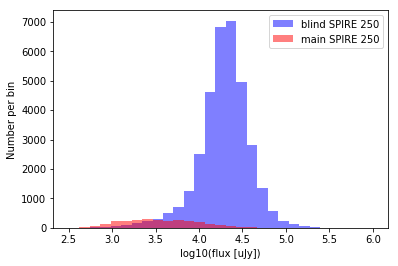

In [32]:
plt.hist(np.log10(1.e3*blind['F_SPIRE_250']), 
         bins=np.linspace(2.5, 6.0, num=30), color='b', alpha=0.5, 
         label = 'blind SPIRE 250')
plt.hist(np.log10(cat['f_spire_250'][~np.isnan(cat['f_spire_250'])]), 
         bins=np.linspace(2.5, 6.0, num=30), color='r', alpha=0.5, 
         label = 'main SPIRE 250')
plt.legend()
plt.xlabel('log10(flux [uJy])')
plt.ylabel('Number per bin')

Text(0,0.5,'Number per bin')

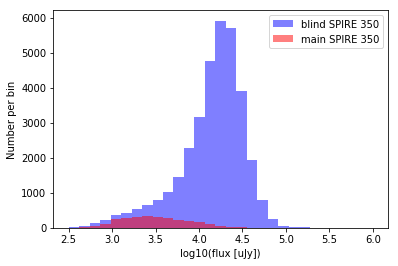

In [41]:
plt.hist(np.log10(1.e3*blind['F_SPIRE_350']), 
         bins=np.linspace(2.5, 6.0, num=30), color='b', alpha=0.5, 
         label = 'blind SPIRE 350')
plt.hist(np.log10(cat['f_spire_350'][~np.isnan(cat['f_spire_350'])]), 
         bins=np.linspace(2.5, 6.0, num=30), color='r', alpha=0.5, 
         label = 'main SPIRE 350')
plt.legend()
plt.xlabel('log10(flux [uJy])')
plt.ylabel('Number per bin')

Text(0,0.5,'Number per bin')

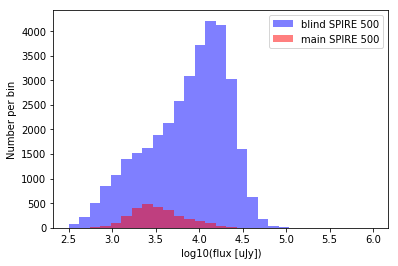

In [42]:
plt.hist(np.log10(1.e3*blind['F_SPIRE_500']), 
         bins=np.linspace(2.5, 6.0, num=30), color='b', alpha=0.5, 
         label = 'blind SPIRE 500')
plt.hist(np.log10(cat['f_spire_500'][~np.isnan(cat['f_spire_500'])]), 
         bins=np.linspace(2.5, 6.0, num=30), color='r', alpha=0.5, 
         label = 'main SPIRE 500')
plt.legend()
plt.xlabel('log10(flux [uJy])')
plt.ylabel('Number per bin')

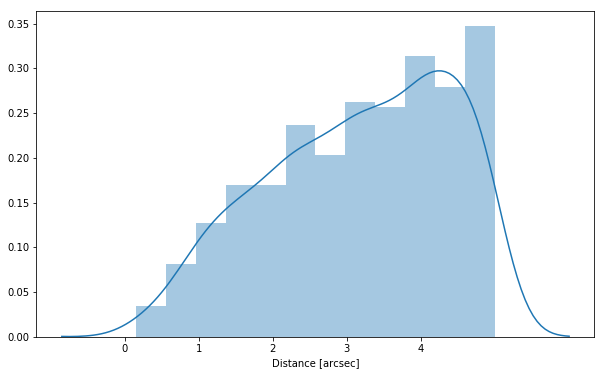

In [46]:
nb_merge_dist_plot(
    SkyCoord(cat['ra'], cat['dec']),
    SkyCoord(blind['RA'], blind['Dec'])
)

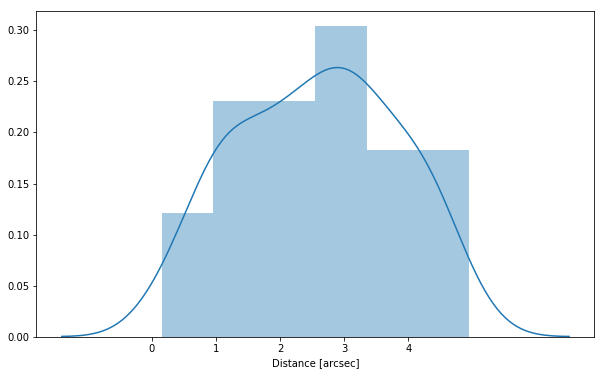

In [47]:
nb_merge_dist_plot(
    SkyCoord(cat['ra'][combined_good], cat['dec'][combined_good]),
    SkyCoord(blind['RA'], blind['Dec'])
)

In [48]:
good_cat = cat[combined_good]

In [51]:
# Given the graph above, we use 0.8 arc-second radius
merge = merge_catalogues(good_cat, blind, "RA", "Dec", radius=5.0*u.arcsec)

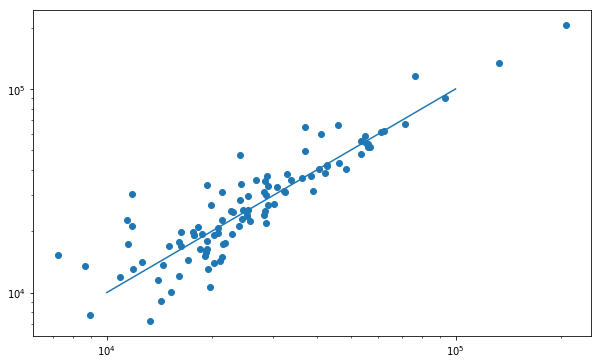

In [59]:
plt.scatter(merge['f_spire_250'], 1.e3*merge['F_SPIRE_250'])
plt.plot([1.e4,1.e5],[1.e4,1.e5])
plt.yscale('log')
plt.xscale('log')